# Here is a detailed script for how one would extrapolate features from the data we get from the neural network.

## This is not a demonstration of how one passes information through a neural network, rather, after the images pass through the NN. If you recall the presentation yesterday,  we had an iterative loop. We focus on the last step in the process, with a snippet shown below:

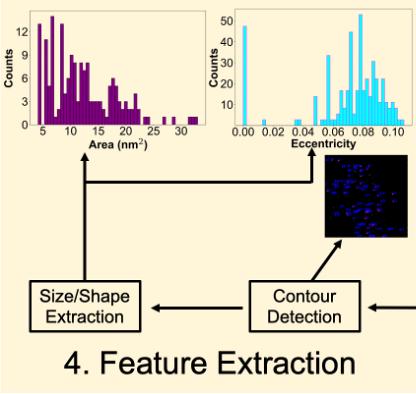

## Email koryburns@virginia.edu for any questions or assistance.

[INFO] 204 Defects found in the micrograph


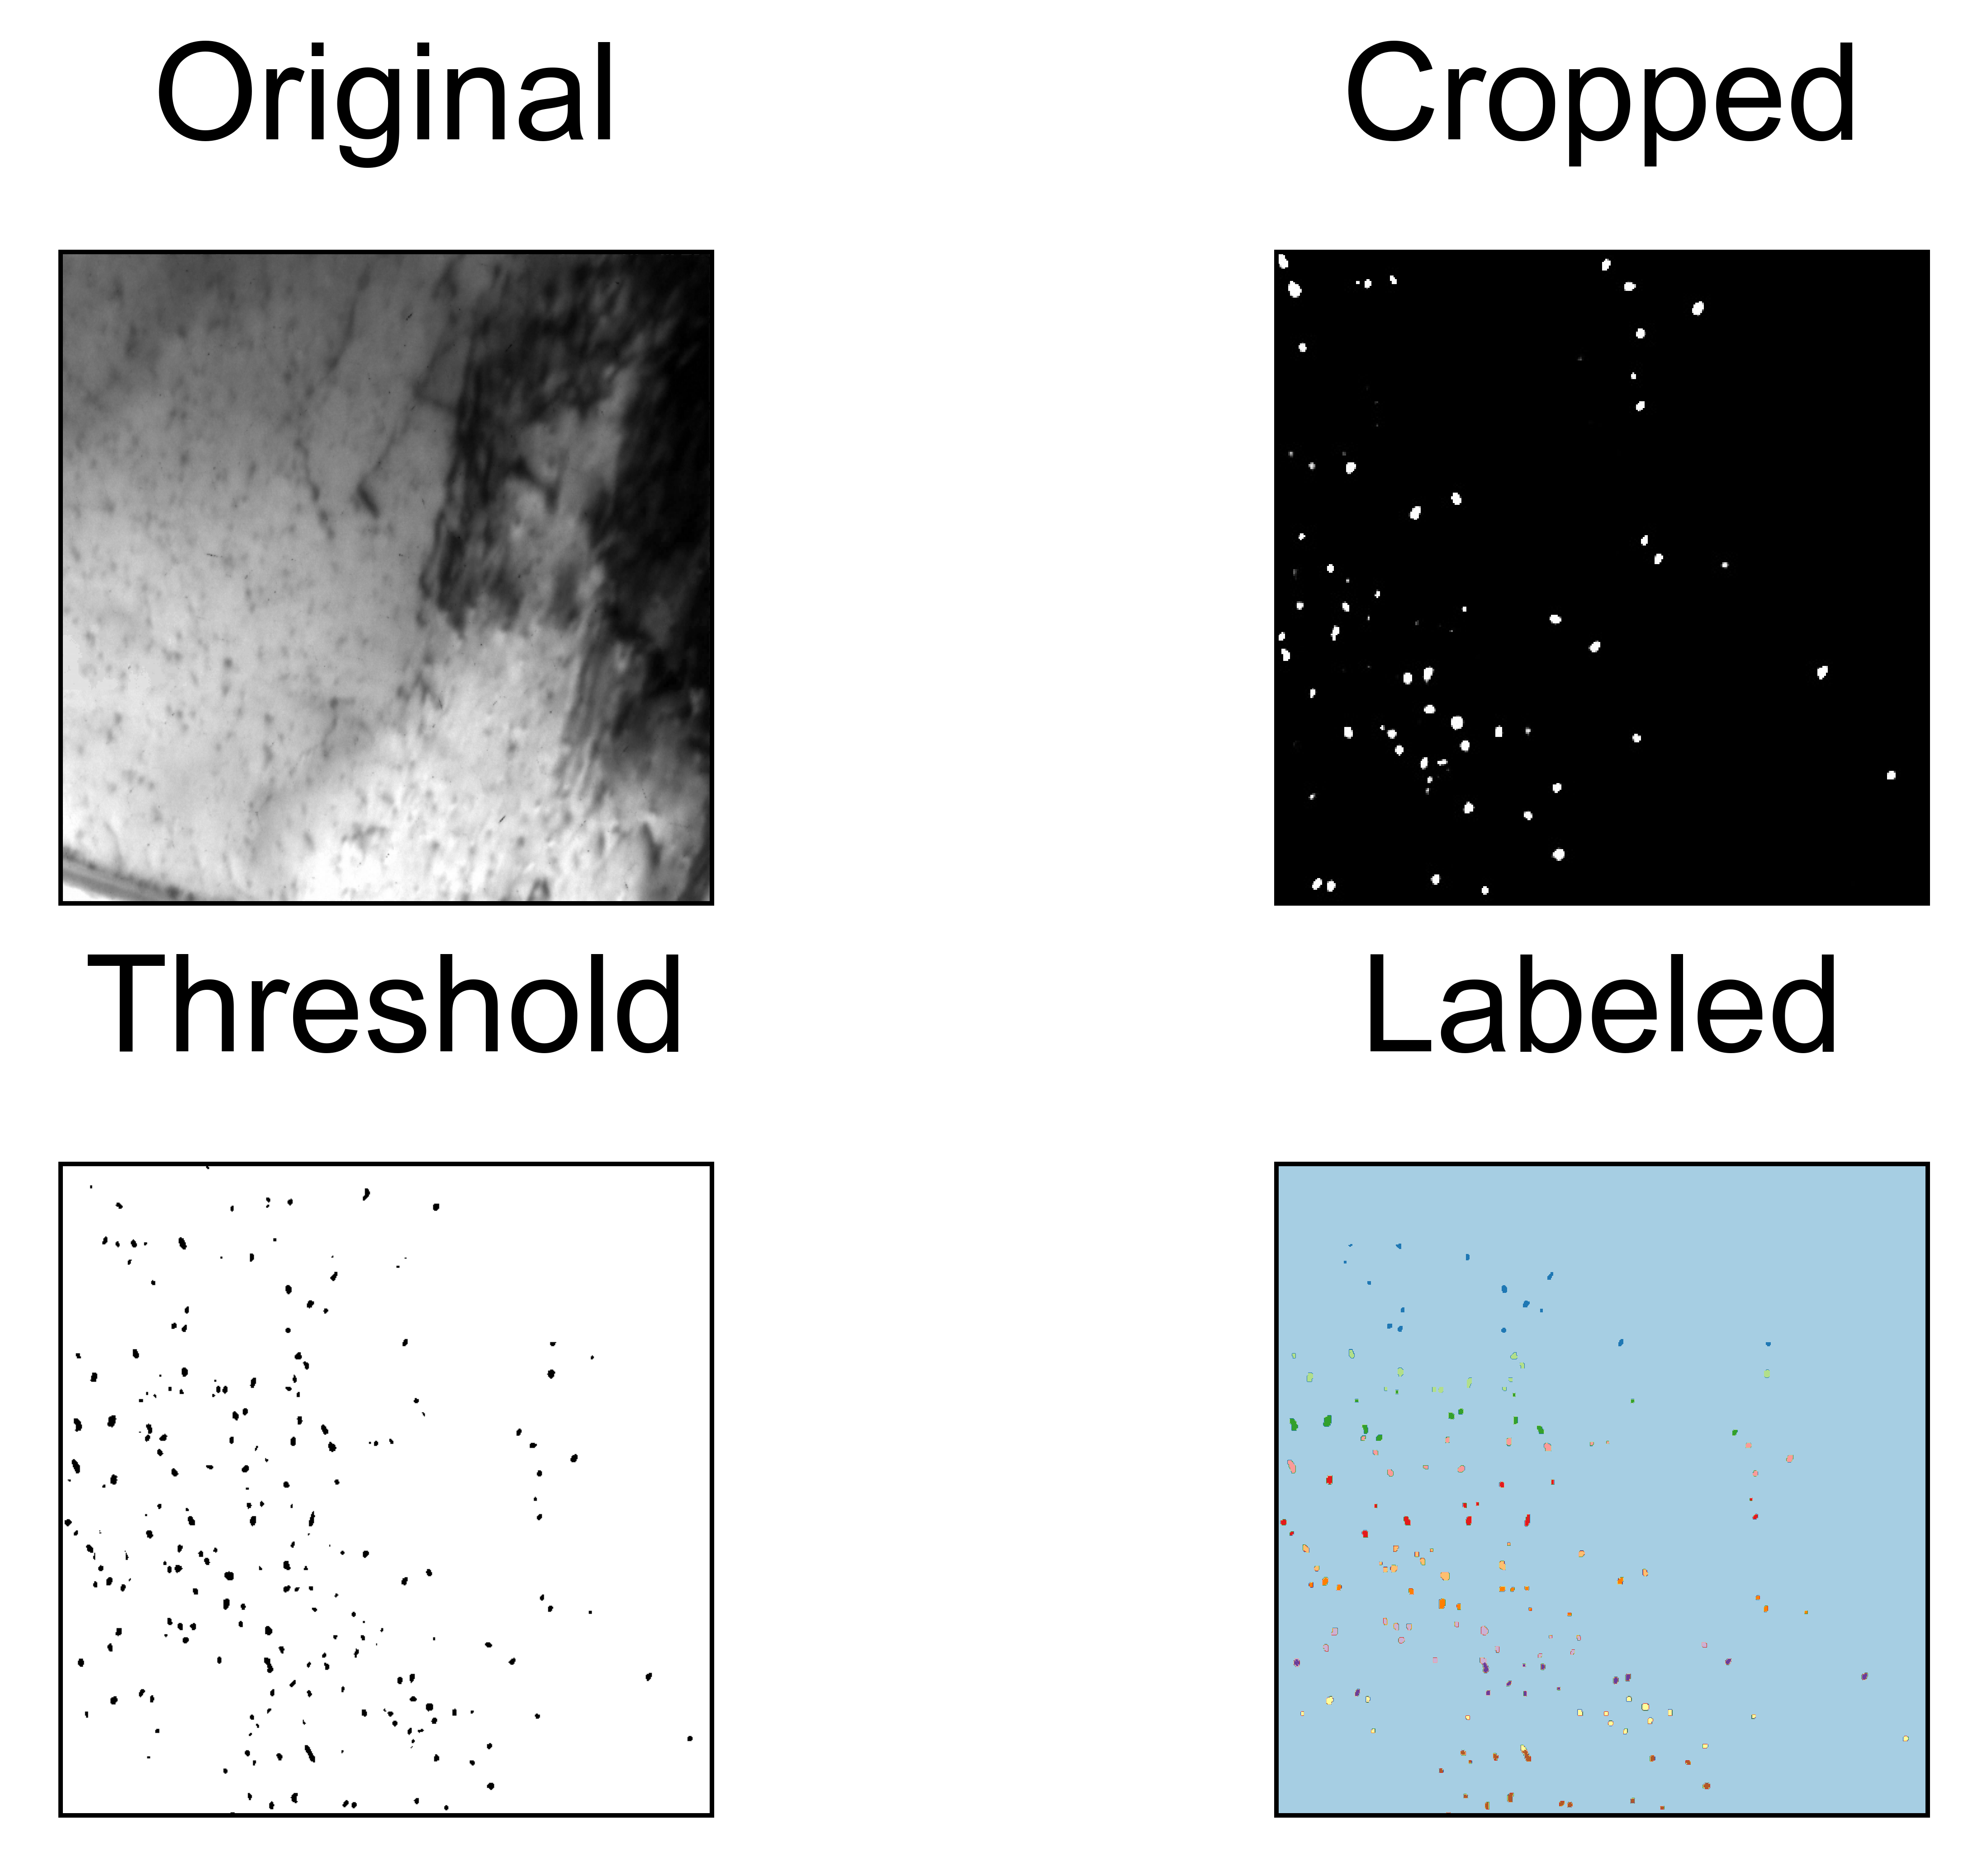

In [1]:
# import the necessary packages
import cv2
import gc
import numpy as np
from matplotlib import font_manager, rc, rcParams
import matplotlib.pyplot as plt
from scipy import ndimage
import seaborn as sns
from tqdm import tqdm
from skimage import io, color, measure
from skimage.restoration import denoise_nl_means
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import pandas as pd
import argparse
import imutils
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

rcParams['figure.dpi'] = 900
rc('font',family='Arial',size=20)
rcParams['axes.titlepad'] = 20
rcParams['mathtext.fontset'] = 'dejavuserif'
ticks_font = font_manager.FontProperties(family='Arial', style='normal',
size=20, weight='normal', stretch='normal')
axis_font = {'fontname':'Arial','fontsize':20}

x,y = 256, 256
w,h = 512, 512

img = cv2.imread('/Users/kj8/Documents/MachineLearning/132.png')
img_original = cv2.imread('/Users/kj8/Documents/MachineLearning/132_original.png')
crop_img = img[x:x+w, y:y+h]

pixels_to_nm = 1/2.955 #1 pixel = 2.955nm

shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
eroded = cv2.erode(thresh, kernel, iterations=1)
dilated= cv2.dilate(eroded, kernel, iterations=1)

#6
D = ndimage.distance_transform_edt(dilated)
localMax = peak_local_max(D, indices=False, min_distance=1,
    labels=dilated)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=dilated)

plt.figure('Original')
plt.subplot(2,2,1)
plt.gca().set_title('Original')
plt.xticks([]), plt.yticks([]) # To hide axes
plt.imshow(img_original, cmap='gray')


plt.subplot(2,2,2)
plt.gca().set_title('Cropped')
plt.xticks([]), plt.yticks([])
plt.imshow(crop_img, cmap='binary_r')

plt.subplot(2,2,3)
plt.gca().set_title('Threshold')
plt.xticks([]), plt.yticks([]) # To hide axes
plt.imshow(thresh, cmap='binary')


plt.subplot(2,2,4)
plt.gca().set_title('Labeled')
plt.xticks([]), plt.yticks([])
plt.imshow(labels, cmap='Paired')


# I can adjust the positions of the subplots to prevent overlapping
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

print("[INFO] {} Defects found in the micrograph".format(len(np.unique(labels)) - 1))

## Okay, so we have a good representation of what our mask looks like, and we labeled the defects with a watershed method that worked pretty good. Most important from above, we can alter the minimum distance between pixels to see set the "sensitivy" of the labeling. This is something that's important to get right, so we'll loop over the defects to create a visual of how well the the labels were identified.

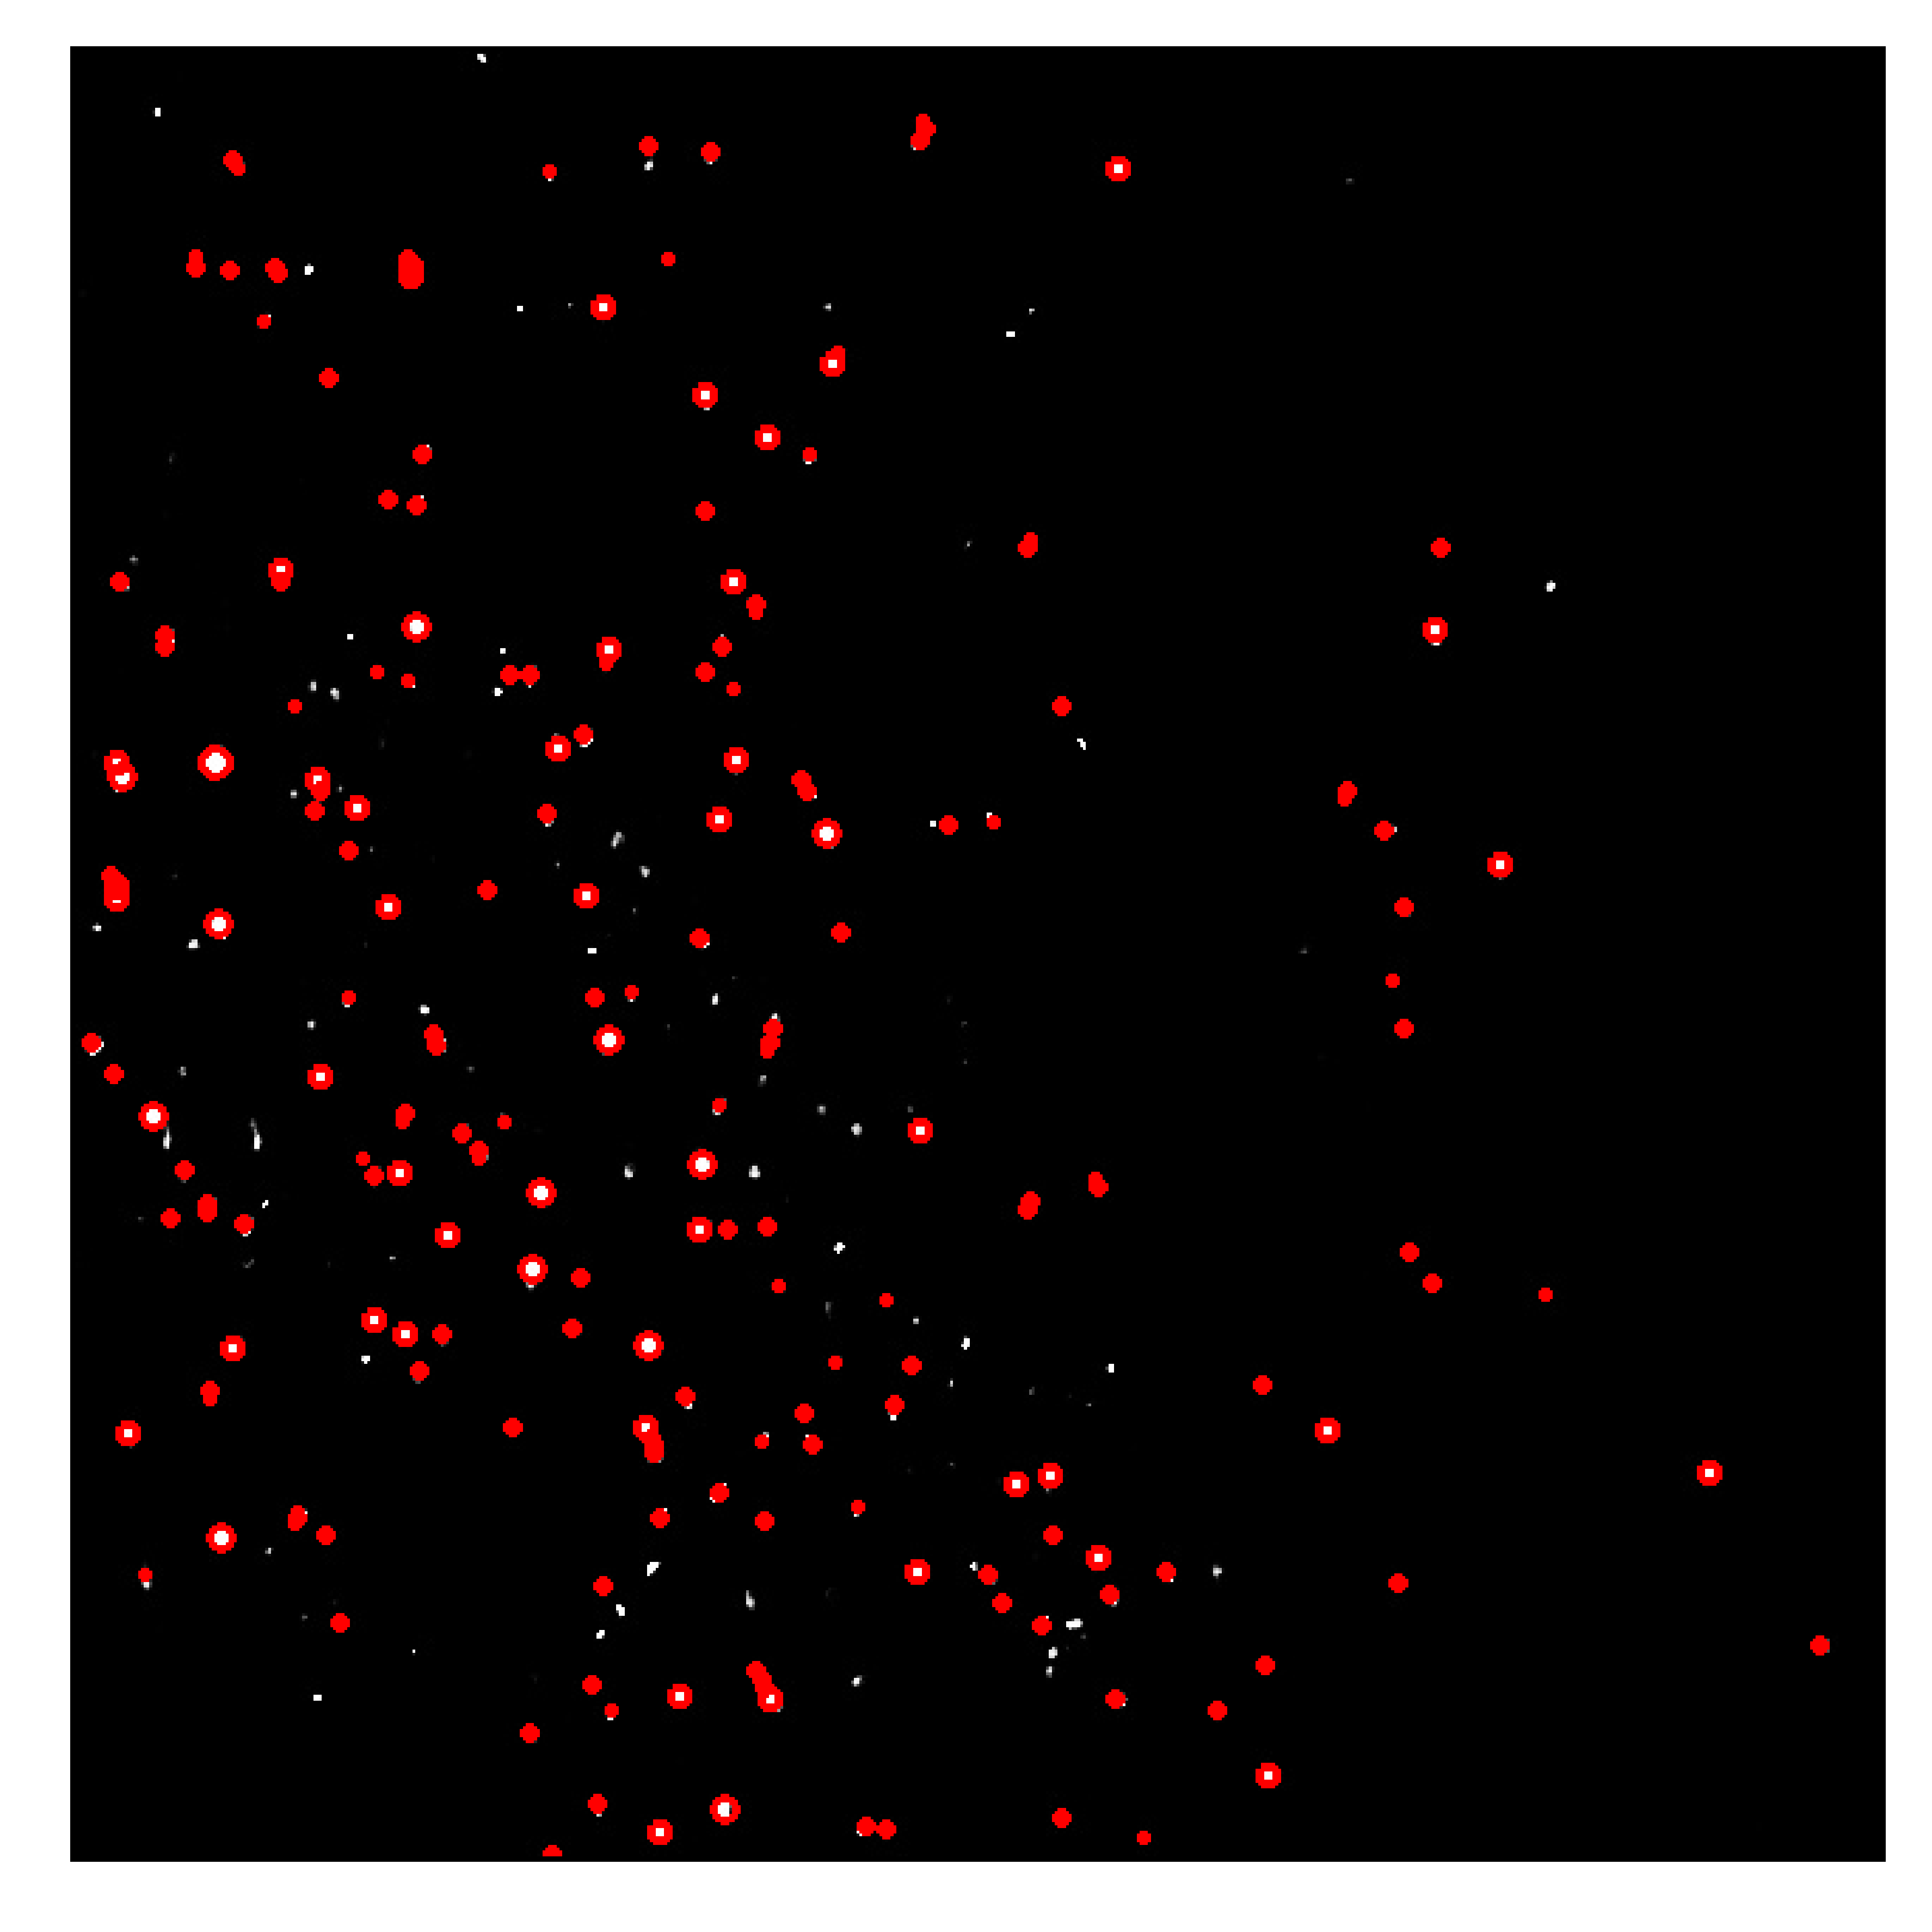

In [2]:
# loop over the unique labels returned by the Watershed algorithm

for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    c = max(cnts, key=cv2.contourArea)
    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(img, (int(x), int(y)), int(r), (255, 0, 0), 2)
    #cv2.putText(img, "#{}".format(label), (int(x) - 10, int(y)),
        #cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image

plt.xticks([]), plt.yticks([])
plt.imshow(img)
plt.savefig('CodeData/132_Contours.png', transparent=False)

## That looks jumbled, but you can still see that most of the defects were identified. For the sake of this tutorial, we'll move on. 

## Now, let's use skimage to define the metrics we care about. Built into this module, we have area, diameter, eccentricity, and the major and minor axis length. We'll also set limits to the sizes of defects that are found. 

In [3]:
clusters = measure.regionprops(labels, img)

propList = ['Area',
           'equivalent_diameter',
           'eccentricity',
           'MajorAxisLength',
            'MinorAxisLength']
    
output_file = open('132_opencv_properties.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n')

for cluster_props in clusters:
    #Output desired properties into excel
    output_file.write(str(cluster_props['Label']))
    
    for i,prop in enumerate(propList):
        if(prop.find('Area') <200):
            to_print = cluster_props[prop]*pixels_to_nm**2
        elif(prop.find('equivalent diameter') < 20):
            to_print = cluster_props[prop]*pixels_to_nm
        elif(prop.find('eccentricity') <1):
            to_print = cluster_props[prop]
        else:
            to_print = cluster_props[prop]
        output_file.write(',' + str(to_print))
    output_file.write('\n')

# Now we have a .csv file with all the data. Let's use different visualization tools to look at the distributions.

In [6]:
rcParams['figure.dpi'] = 900
rc('font',family='Arial',size=40)
rcParams['axes.titlepad'] = 40
rcParams['mathtext.fontset'] = 'dejavuserif'
ticks_font = font_manager.FontProperties(family='Arial', style='normal',
size=40, weight='normal', stretch='normal')
axis_font = {'fontname':'Arial','fontsize':40}

data = pd.read_csv('132_opencv_properties.csv')

plt.rcParams["figure.figsize"] = (11,8)

x = data.Area * 4
mx = int(data['Area'].max())
mn = int(data['Area'].min())
md = data['Area'].median()
de = data['Area'].describe()

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, color='purple', edgecolor='black', density=False)

ax.set_xlabel('Area (nm$^2$)', weight = 'bold')
ax.set_ylabel('Counts', weight = 'bold')
ax.set_xticks([5, 10, 15, 20, 25, 30])
ax.set_yticks([0, 5, 10, 15, 20, 25])

plt.tight_layout()
plt.savefig('CodeData/132_Area_Histogram.png', transparent=True)
print('Median', md)
print(de)

Median 2.175898488609457
count    167.000000
mean       2.520147
std        1.322185
min        0.916168
25%        1.603294
50%        2.175898
75%        3.092066
max        8.245510
Name: Area, dtype: float64


In [7]:
#data = pd.read_csv('Machine Learning Project/Processed_400C_He_Implant_500c_anneal/0_opencv_properties.csv')
x = data.equivalent_diameter * 4

mx = int(data['equivalent_diameter'].max())
mn = int(data['equivalent_diameter'].min())
md = data['equivalent_diameter'].median() 
de = data['equivalent_diameter'].describe()

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, color='gold', edgecolor='silver', density=False)

# add a 'best fit' line
#ax.plot(bins, y, '--')
ax.set_xlabel('Diameter (nm)', weight = 'bold')
ax.set_ylabel('Counts', weight = 'bold')

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
#plt.show()
print('Median', md)
print(de)
plt.savefig('CodeData/132_Diameter_Histogram.png')
#plt.savefig('Machine Learning Project/Processed_400C_He_Implant_650c_anneal/Diameter/350_Diameter_Histogram.png')

Median 0.5632703478707327
count    167.000000
mean       0.587524
std        0.149732
min        0.365498
25%        0.483508
50%        0.563270
75%        0.671463
max        1.096494
Name: equivalent_diameter, dtype: float64


In [8]:
rcParams['figure.dpi'] = 900
rc('font',family='Arial',size=40)
rcParams['axes.titlepad'] = 40
rcParams['mathtext.fontset'] = 'dejavuserif'
ticks_font = font_manager.FontProperties(family='Arial', style='normal',
size=40, weight='normal', stretch='normal')
axis_font = {'fontname':'Arial','fontsize':40}

plt.rcParams["figure.figsize"] = (11,8)

#data = pd.read_csv('Machine Learning Project/Processed_400C_He_Implant_500c_anneal/0_opencv_properties.csv')
x = data.eccentricity

mx = int(data['eccentricity'].max())
mn = int(data['eccentricity'].min())
md = data['eccentricity'].median()
de = data['eccentricity'].describe()

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, color='cyan', edgecolor='magenta', density=True)

# add a 'best fit' line
#ax.plot(bins, y, '--')
ax.set_xlabel('Eccentricity', weight = 'bold')
ax.set_ylabel('Counts', weight = 'bold')
ax.set_xticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.10])
ax.set_yticks([15, 30, 45, 60, 75])
#ax.set_title(r'Circularity of Defects')


# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
#plt.show()
print('Median', md)
print(de)

plt.tight_layout()
plt.savefig('CodeData/132_Eccentricity_Histogram.png', transparent=True)
#plt.savefig('Machine Learning Project/Processed_400C_He_Implant_650c_anneal/Eccentricity/350_Eccentricity_Histogram.png')

Median 0.0759828468000762
count    167.000000
mean       0.068444
std        0.023985
min        0.000000
25%        0.062311
50%        0.075983
75%        0.081505
max        0.108347
Name: eccentricity, dtype: float64


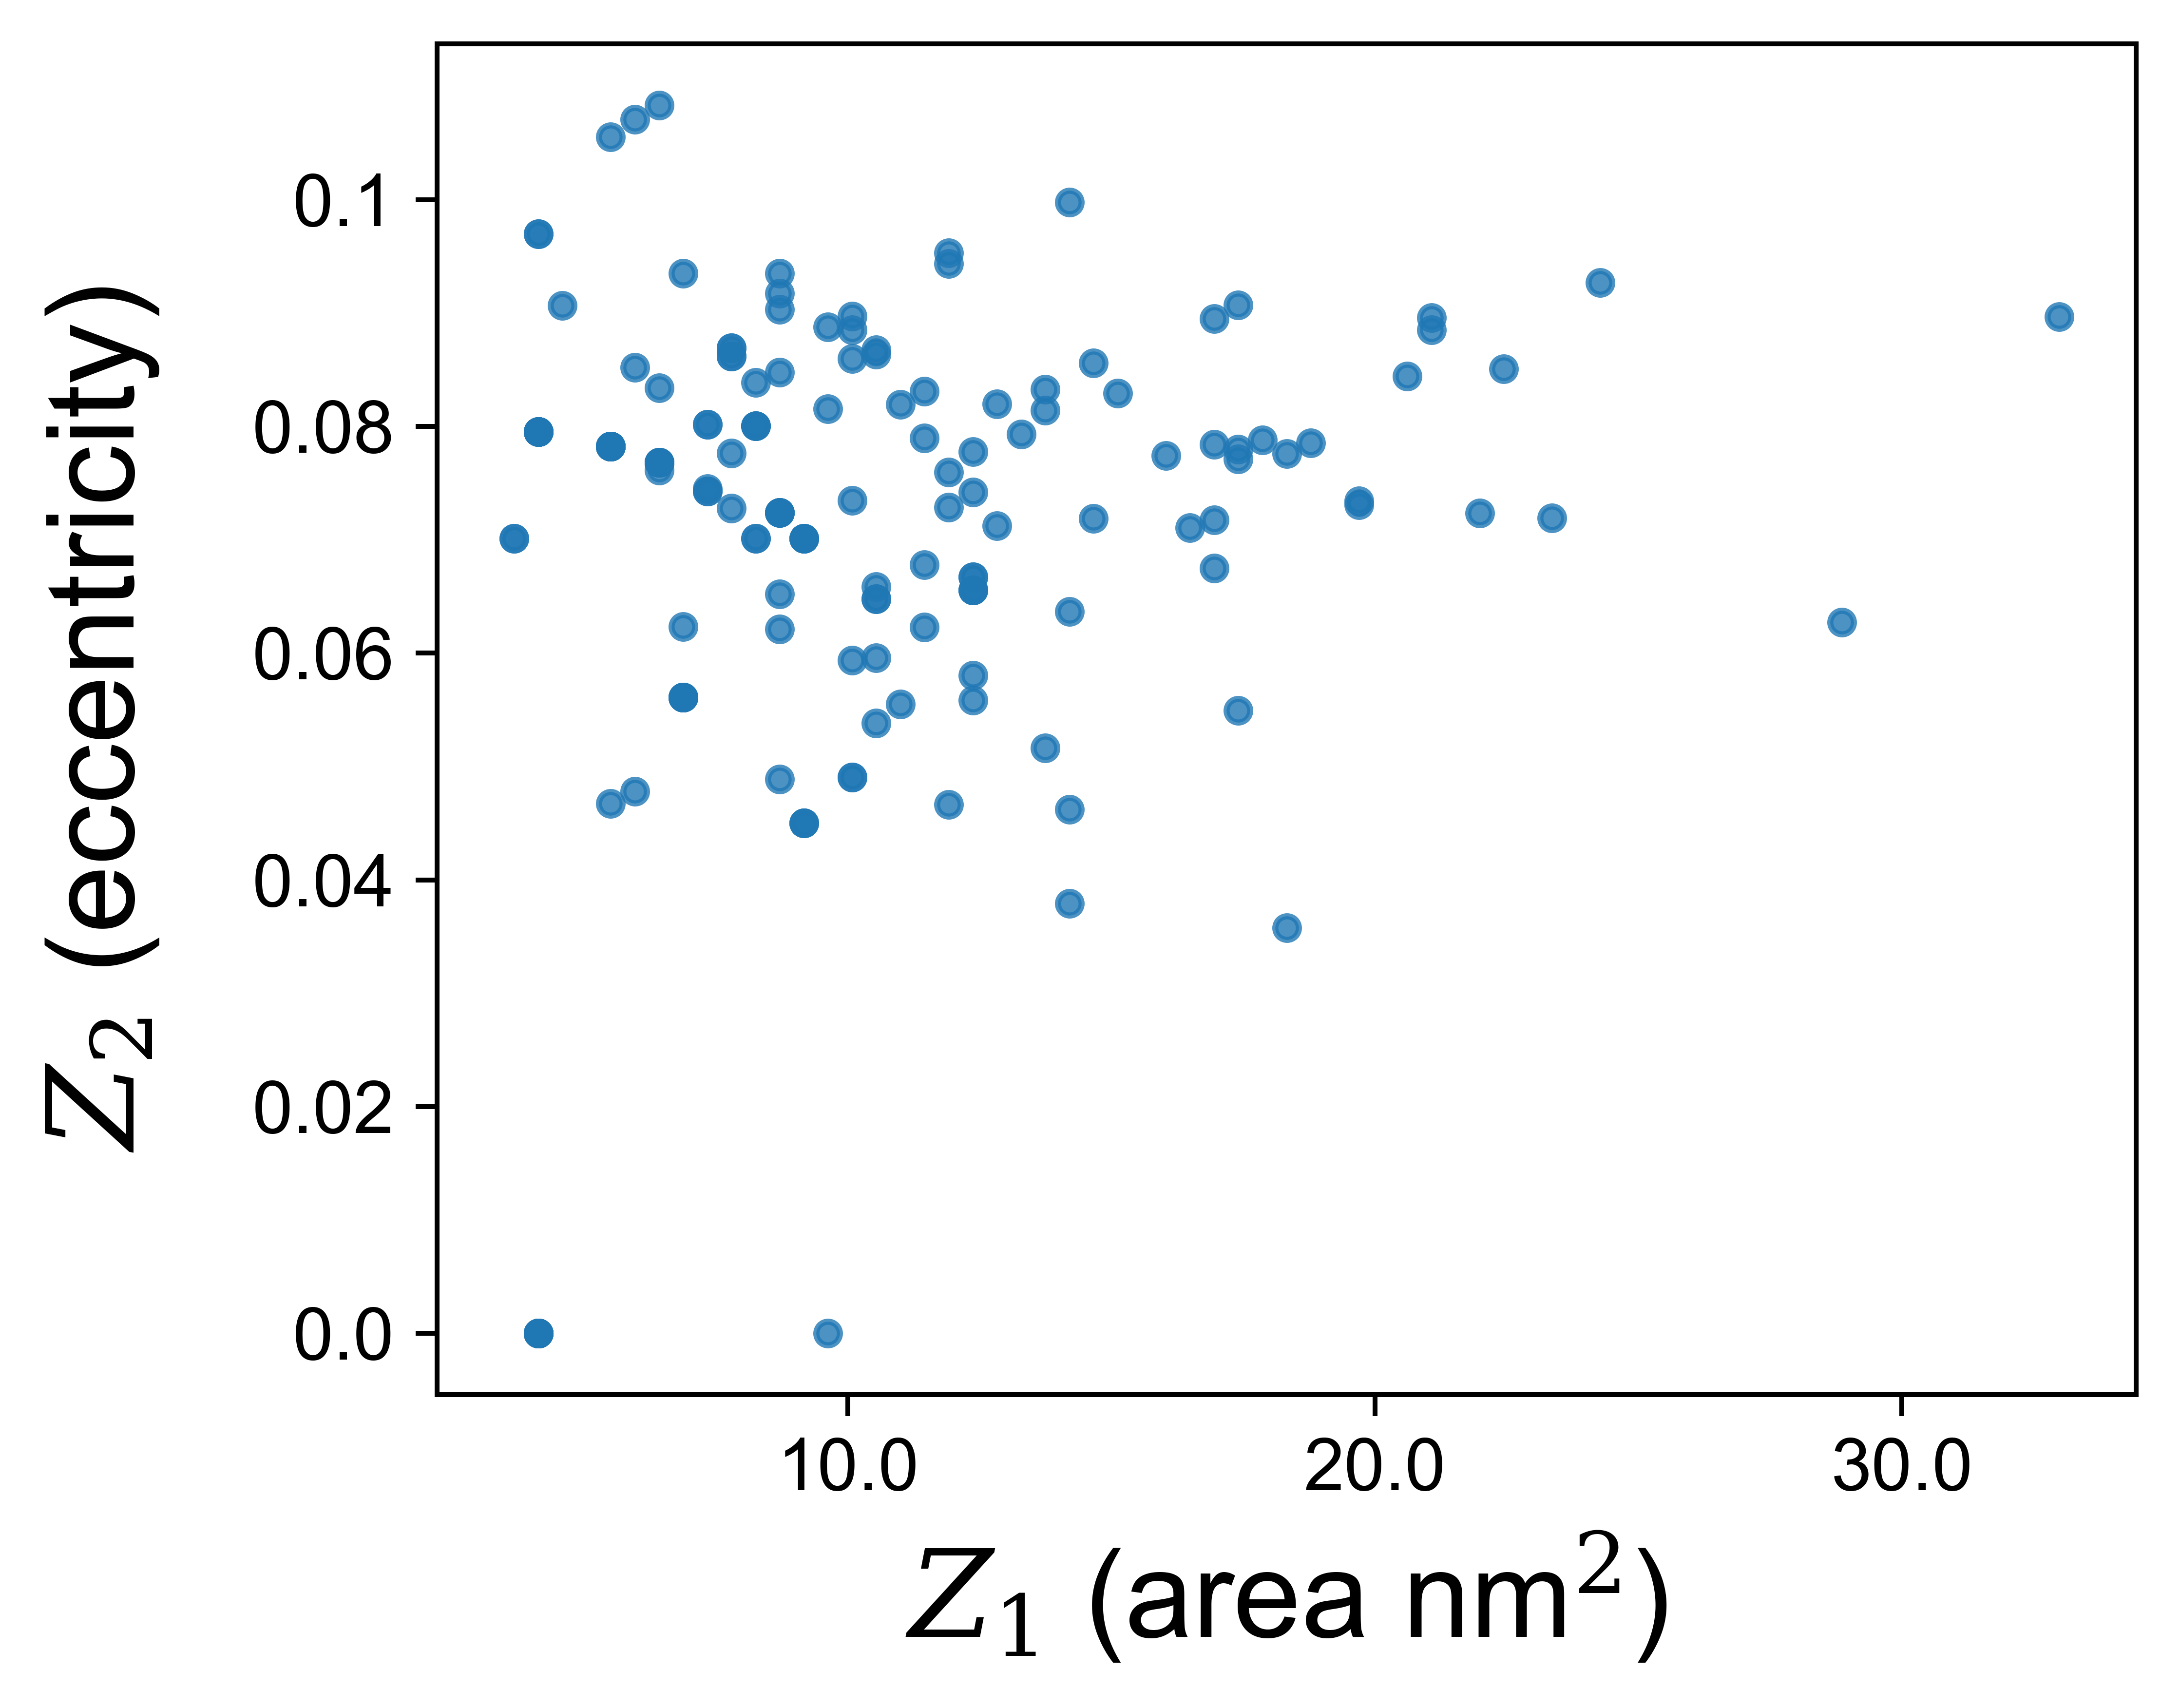

In [9]:
x1 = data.Area * 4
x2 = data.eccentricity

plt.figure(figsize=(5,4), dpi = 900)
ax = sns.regplot(x=x1, y=x2, fit_reg = False, scatter_kws={"s": 15})
#ax = sns.kdeplot(x=x2, y=x3, cmap="Reds", shade=True, thresh = 0.05, cut = 0, alpha = 0.6, cbar = True)
ax.set_xlabel(xlabel = '$Z_1$ (area nm$^2$)', fontdict={'fontsize' : 20})
ax.set_ylabel(ylabel = '$Z_2$ (eccentricity)', fontdict={'fontsize' : 20}, rotation = 90, labelpad = 15)
ax.set_yticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.10])
ax.set_xticklabels(np.round(ax.get_xticks(), decimals=2), size = 12)
ax.set_yticklabels(np.round(ax.get_yticks(), decimals=2), size = 12)
ax.figure.axes[-1].yaxis.label.set_size(20)

plt.savefig('CodeData/132_RegPlot.png', transparent=True)

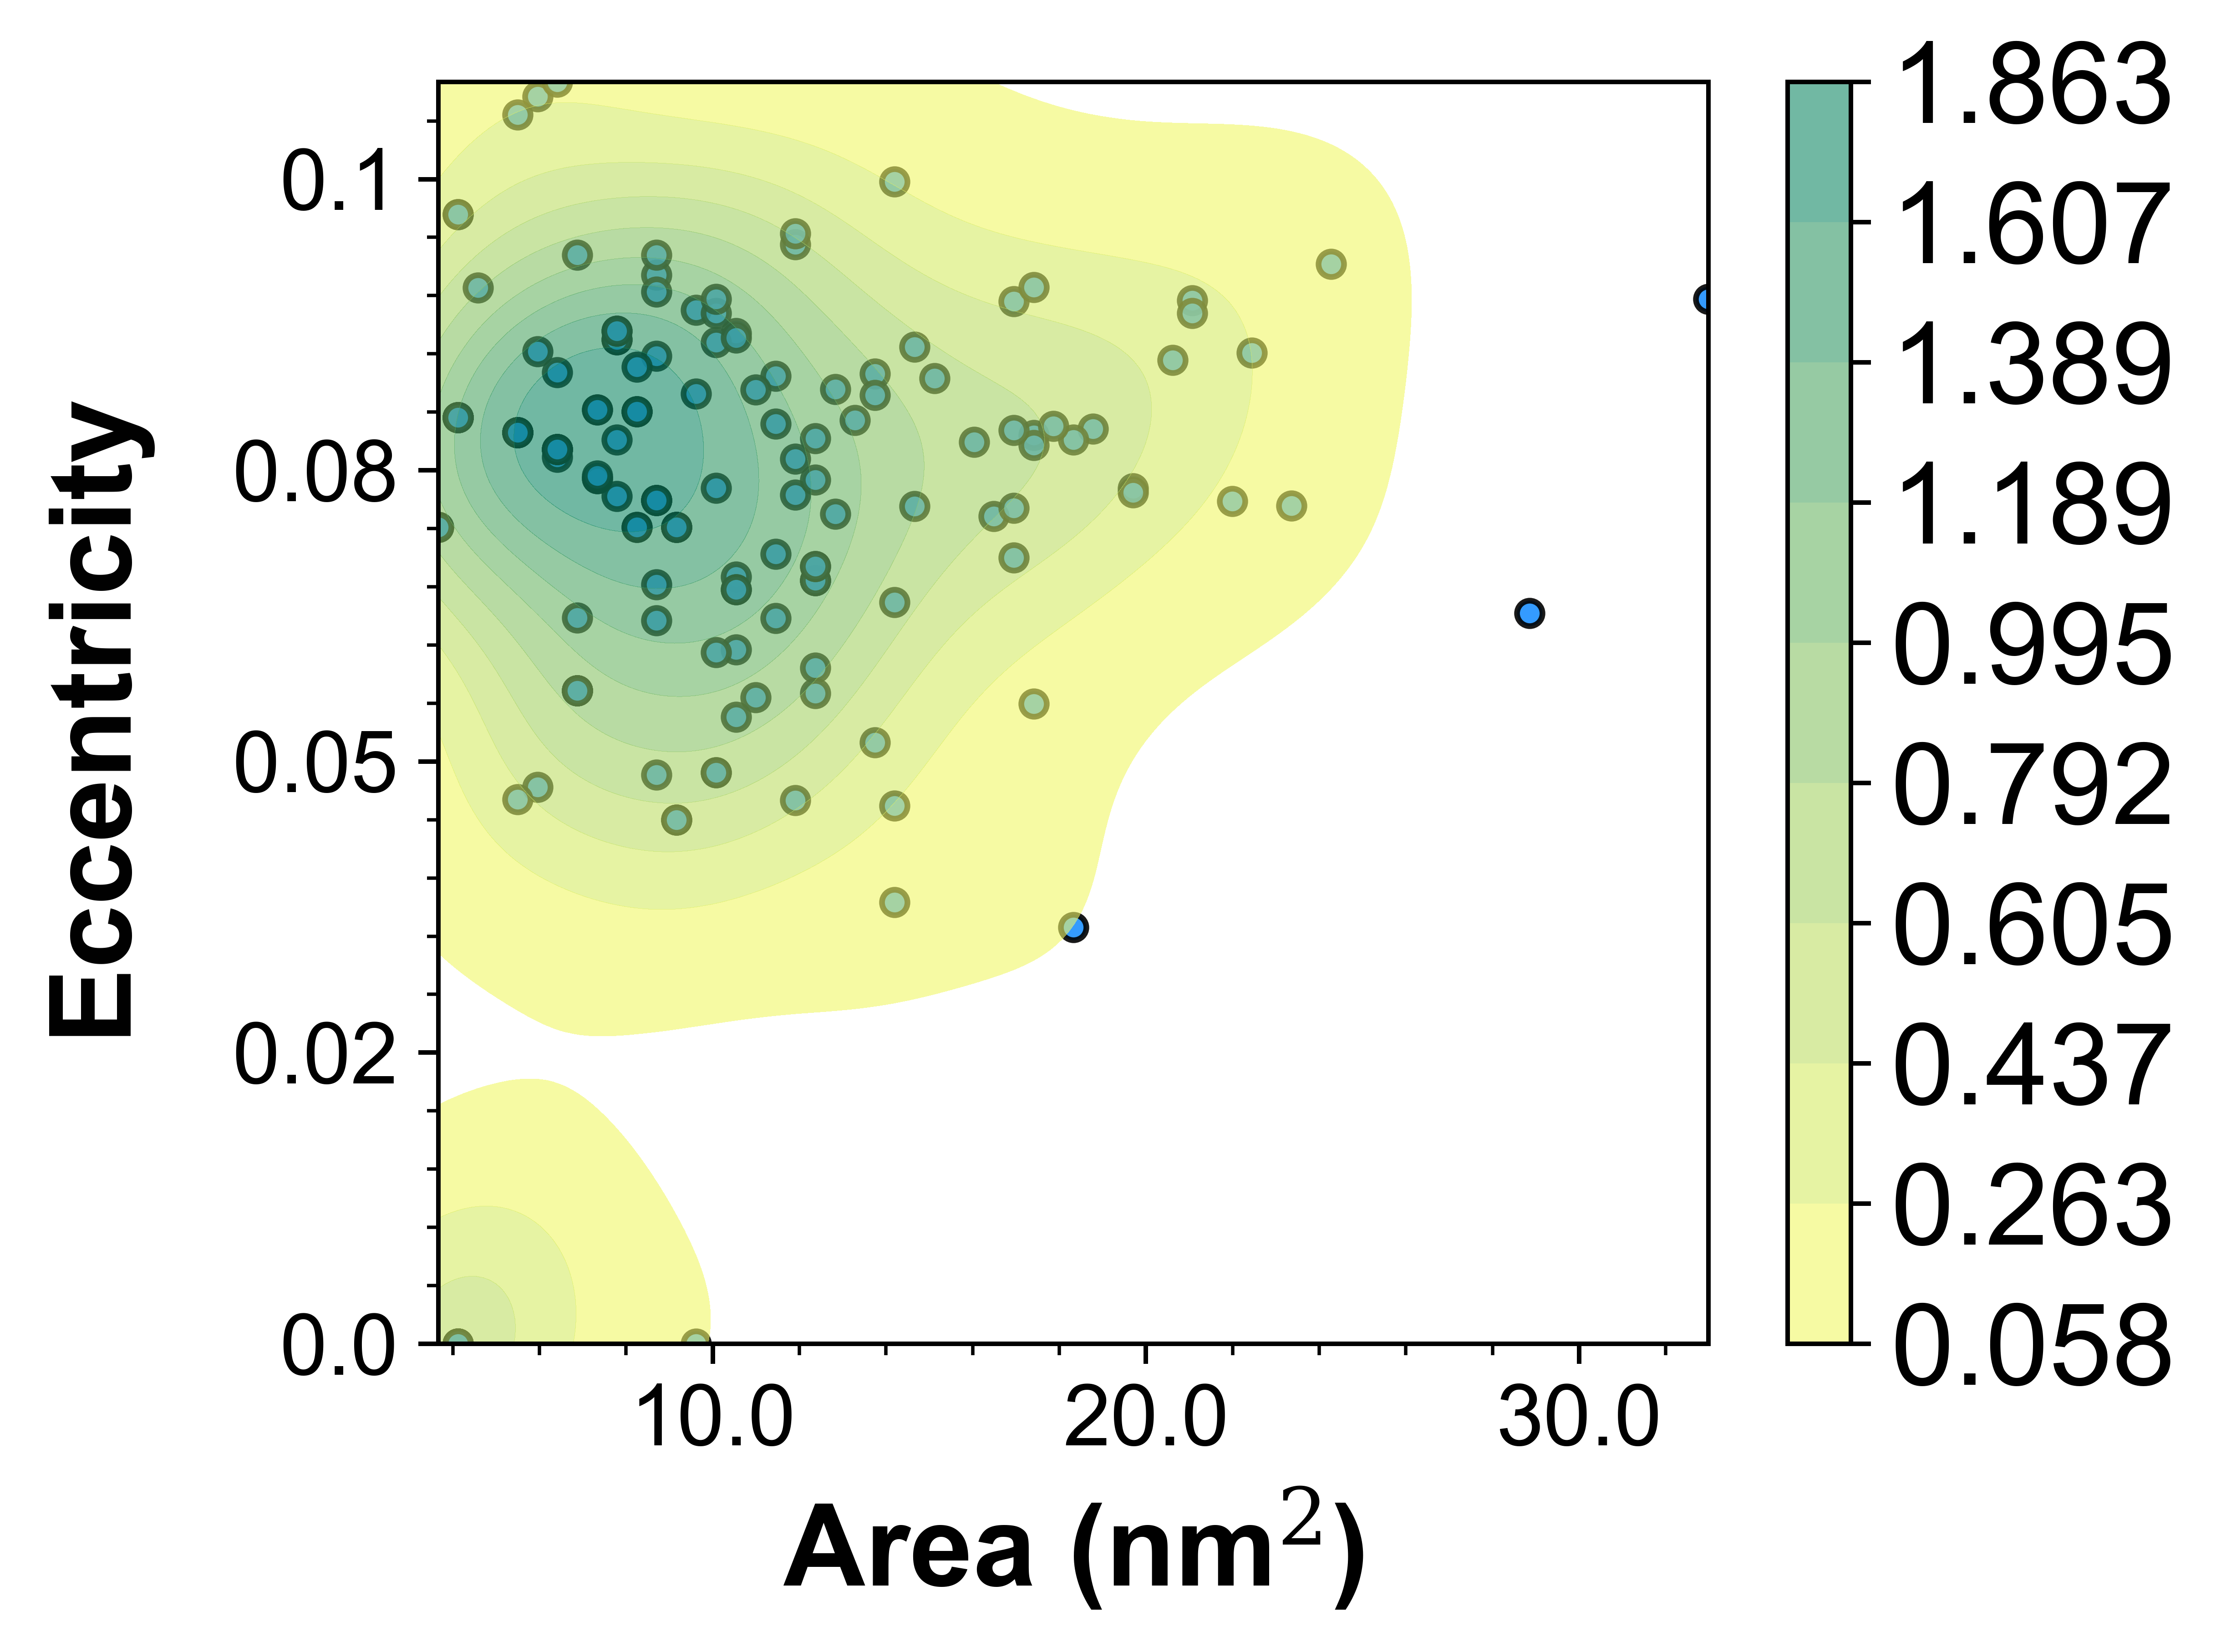

In [12]:
rcParams['figure.dpi'] = 900
rc('font',family='Arial',size=20)
rcParams['axes.titlepad'] = 20
rcParams['mathtext.fontset'] = 'dejavuserif'
ticks_font = font_manager.FontProperties(family='Arial', style='normal',
size=20, weight='normal', stretch='normal')
axis_font = {'fontname':'Arial','fontsize':20}

x1 = data.eccentricity
x2 = data.Area * 4
# x3 = data.Mean_Ecc
# x4 = (x2 * 0.9) + 0.1
# x5 = (x2 * 1.1) - 0.1

plt.figure(figsize=(5,4))
ax = sns.regplot(x=x2, y=x1, color="DodgerBlue", fit_reg = False, scatter_kws={"s": 20, "alpha":0.9, 'edgecolor':'black'}) #scatter_kws={'linewidths':1,'edgecolor':'k'}
ax = sns.kdeplot(x=x2, y=x1, cmap="summer_r", fill=True, thresh = 0.03, cut = 0, alpha = 0.6, cbar = True)
ax.set_xlabel(xlabel = 'Area (nm$^2$)', fontdict={'fontsize' : 20}, weight='bold')
ax.set_ylabel(ylabel = 'Eccentricity', fontdict={'fontsize' : 20}, weight='bold', rotation = 90, labelpad = 15)
ax.set_xticklabels(np.round(ax.get_xticks(), decimals=2), size = 15)
ax.set_yticklabels(np.round(ax.get_yticks(), decimals=2), size = 15)
ax.minorticks_on()
ax.figure.axes[-1].yaxis.label.set_size(4)

plt.savefig('CodeData/132_KDEplot.png', transparent=True)

# Okay so we have a lot of cool plots, but let's say you have a ton of different images to look at. This process would be tedious, so I've done the work for you. We can create a loop to get all this information from multiple images at a time

In [13]:
def run_analysis(filename):
    rcParams['figure.dpi'] = 900
    rc('font',family='Arial',size=20)
    rcParams['axes.titlepad'] = 20
    rcParams['mathtext.fontset'] = 'dejavuserif'
    ticks_font = font_manager.FontProperties(family='Arial', style='normal',
    size=20, weight='normal', stretch='normal')
    axis_font = {'fontname':'Arial','fontsize':20}

    DIR = '/Users/kj8/Documents/MachineLearning/Workshop/'
    img = io.imread(DIR + 'PredictedMasks/' + filename)
    prefix = filename.split('.')[0]

    pixels_to_nm = 4/2.955

#     shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
#     gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(thresh, kernel, iterations=1)
    dilated= cv2.dilate(eroded, kernel, iterations=1)

    D = ndimage.distance_transform_edt(dilated)
    localMax = peak_local_max(D, indices=False, min_distance=2,
        labels=dilated)
    
    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then appy the Watershed algorithm
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=dilated)


    # loop over the unique labels returned by the Watershed
    # algorithm
    for label in np.unique(labels):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0:
            continue
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(img.shape, dtype="uint8")
        mask[labels == label] = 255
        # detect contours in the mask and grab the largest one
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
    
        c = max(cnts, key=cv2.contourArea)
        # draw a circle enclosing the object
        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(img, (int(x), int(y)), int(r), (255, 0, 0), 2)
        cv2.putText(img, "#{}".format(label), (int(x) - 10, int(y)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.imwrite(DIR + 'Processed/IMG/' + prefix + '_final.jpg', img)



    clusters = measure.regionprops(labels, img)

    propList = ['Area',
               'equivalent_diameter',
               'eccentricity',
               'MajorAxisLength',
                'MinorAxisLength']
    
    output_file = open(DIR + 'Processed/CSV/' + prefix + '_csv.csv', 'w')
    output_file.write(',' + ",".join(propList) + '\n')

    for cluster_props in clusters:
        #Output desired properties into excel
        output_file.write(str(cluster_props['Label']))
    
        for i,prop in enumerate(propList):
            if(prop.find('Area') <200):
                to_print = cluster_props[prop]*pixels_to_nm**2
            elif(prop.find('equivalent diameter') < 20):
                to_print = cluster_props[prop]*pixels_to_nm
            elif(prop.find('eccentricity') <1):
                to_print = cluster_props[prop]
            else:
                to_print = cluster_props[prop]
            output_file.write(',' + str(to_print))
        output_file.write('\n')
    output_file.close()




    rcParams['figure.dpi'] = 900
    rc('font',family='Arial',size=20)
    rcParams['axes.titlepad'] = 20
    rcParams['mathtext.fontset'] = 'dejavuserif'
    ticks_font = font_manager.FontProperties(family='Arial', style='normal',
    size=20, weight='normal', stretch='normal')
    axis_font = {'fontname':'Arial','fontsize':20}

    data = pd.read_csv(DIR + 'Processed/CSV/' + prefix + '_csv.csv')

    x = data.Area
    mx = int(data['Area'].max())
    mn = int(data['Area'].min())
    md = data['Area'].median()
    de = data['Area'].describe()


    #counts = plt.legend(handles=[mx])

    num_bins = 50

    fig, ax = plt.subplots()

    # the histogram of the data
    n, bins, patches = ax.hist(x, num_bins, color='purple', edgecolor='black', density=False)

    ax.set_xlabel('Area (nm$^2$)')
    ax.set_ylabel('Counts')
    ax.set_title(r'Size Distribution of Defects')
    
    plt.savefig(DIR + 'Processed/AREA/' + prefix + '_Area_Histogram.png')
    plt.close()

    
    x = data.equivalent_diameter

    mx = int(data['equivalent_diameter'].max())
    mn = int(data['equivalent_diameter'].min())
    md = data['equivalent_diameter'].median() 
    de = data['equivalent_diameter'].describe()

    num_bins = 50

    fig, ax = plt.subplots()

    # the histogram of the data
    n, bins, patches = ax.hist(x, num_bins, color='gold', edgecolor='silver', density=False)

    ax.set_xlabel('Diameter (nm)')
    ax.set_ylabel('Counts')
    ax.set_title(r'Size Distribution of Defects')

    plt.savefig(DIR + 'Processed/DIAMETER/' + prefix + '_Diameter_Histogram.png')
    plt.close()


    x = data.eccentricity

    mx = int(data['eccentricity'].max())
    mn = int(data['eccentricity'].min())
    md = data['eccentricity'].median()
    de = data['eccentricity'].describe()

    num_bins = 50

    fig, ax = plt.subplots()

    # the histogram of the data
    n, bins, patches = ax.hist(x, num_bins, color='cyan', edgecolor='magenta', density=False)

    ax.set_xlabel('Eccentricity')
    ax.set_ylabel('Counts')
    ax.set_title(r'Circularity of Defects')

    plt.savefig(DIR + 'Processed/ECCENTRICITY/' + prefix + '_Eccentricity_Histogram.png')
    plt.close()
    del data
    del img

def main_loop() :
    DIR = '/Users/kj8/Documents/MachineLearning/Workshop/'
    for number in tqdm(range(0,6)) :
        filename =  str(number) + '.png'
        run_analysis(filename)
        gc.collect()

main_loop()

100%|█████████████████████████████████████████████| 6/6 [00:50<00:00,  8.39s/it]


# After we've iterated over all the data, we can look at some of the "time-series" information from the micrographs.

## 

In [14]:
rcParams['figure.dpi'] = 900
rc('font',family='Arial',size=30)
rcParams['axes.titlepad'] = 30
rcParams['mathtext.fontset'] = 'dejavuserif'
ticks_font = font_manager.FontProperties(family='Arial', style='normal',
size=30, weight='normal', stretch='normal')
axis_font = {'fontname':'Arial','fontsize':30}

data = pd.read_csv('/Users/kj8/Documents/BSD_Summary.csv')


plt.figure(figsize=(14, 8))

#x = data.Frame * (1/15)
x = data.Fluence
y = data.Count * 2.2769
y = y/1.546691584E-20


plt.xlabel('Fluence (cm$^{-2}$)')
plt.ylabel('Defect Density (10$^{22}$/m$^{3}$)')
plt.xlim(3.5e10, 1.1e13)

plt.axvspan(0, 2e11, color='orange', ec='black', alpha=0.1, lw=2, label='Incubation Zone')
plt.axvspan(2e11, 1.3e12, color='LimeGreen',ec='black', alpha=0.2, lw=0.1, label='Non-interaction Zone')
plt.axvspan(1.3e12, 8e12, color='SkyBlue', ec='black',alpha=0.2, lw=0.1, label='Interaction Zone')
plt.axvspan(8e12, 1.3e13, color='silver', ec='black',alpha=0.2, lw=0.1, label='Saturation')
plt.scatter(x, y, marker='s', s=80, color='cyan', edgecolor='magenta', alpha=0.5)
plt.xscale("log")

#plt.plot(x, y, label='Pristine', color='red')
#plt.plot(x1, y1, label='1E14 cm$^{-2}$', color='orange')
#plt.plot(x2, y2, label='1E15 cm$^{-2}$',color='green')

plt.legend(loc=2, prop={'size': 20})